In [1]:
import os
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
sys.path.append('/Users/aghavamp/Desktop/Projects/AnatSearchlight')
sys.path.append('/Users/aghavamp/Desktop/Projects/SUITPy')
import getpass
import importlib
import tqdm

import scipy.io as sio
import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import seaborn as sns
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel
import glob
import matplotlib.patches as patches
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



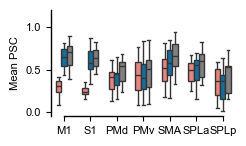

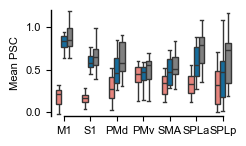

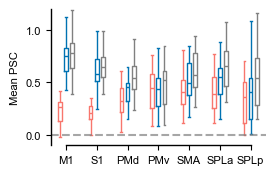

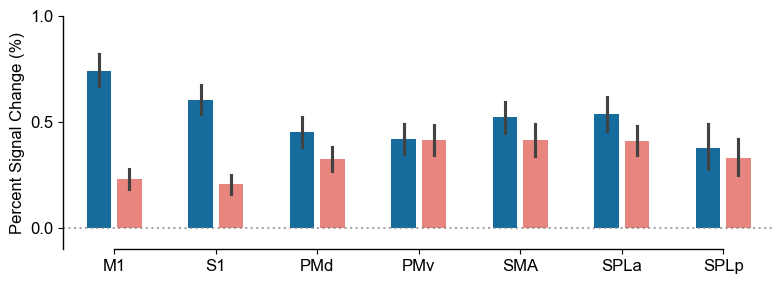

  region     t-stat  dof         p-val
0    SMA   6.125534   23  3.005496e-06
1    PMv   0.458900   23  6.506132e-01
2    PMd   5.042643   23  4.196631e-05
3     M1  13.228299   23  3.086322e-12
4     S1  15.378387   23  1.355897e-13
5   SPLa   4.486176   23  1.675493e-04
6   SPLp   1.491230   23  1.494901e-01


In [5]:
regions = ['SMA','PMv','PMd','M1','S1','SPLa','SPLp']
region_code = [5, 4, 3, 2, 1, 7, 8]
hem = ['L', 'R']
conditions = ['rhand','lhand','bi']
num_subj = 12

data = nb.load(os.path.join(analysisDir, 'psc.dscalar.nii'))
scalar_axis = data.header.get_axis(0)
row_names = [ax[0] for ax in scalar_axis]
idx_lhand = [i for i in range(len(row_names)) if 'lhand' in row_names[i]][0:num_subj]
idx_rhand = [i for i in range(len(row_names)) if 'rhand' in row_names[i]][0:num_subj]
idx_bi = [i for i in range(len(row_names)) if 'bi' in row_names[i]][0:num_subj]
indices = {'lhand': idx_lhand,
           'rhand': idx_rhand,
           'bi': idx_bi}
cons = data.get_fdata() 

ROI_L = nb.load('/Volumes/Diedrichsen_data$/data/Atlas_templates/fs_LR_32/ROI.32k.L.label.gii')
ROI_R = nb.load('/Volumes/Diedrichsen_data$/data/Atlas_templates/fs_LR_32/ROI.32k.R.label.gii')
ROI = {'L': ROI_L.darrays[0].data,
        'R': ROI_R.darrays[0].data}

ana = {'sn':[], 
       'region':[],
       'hem':[],
       'cond':[],
       'psc':[],
       'lateral':[]
}

for hidx, h in enumerate(hem):
    for r, roi in enumerate(regions):
        for cond in conditions:
            idx = indices[cond]
            for i in range(num_subj):
                con_sn = cons[idx[i], hidx*32492:(hidx+1)*32492] # left hem data
                region_con = con_sn[ROI[h]==region_code[r]]

                ana['psc'].append(np.nanmean(region_con))
                ana['sn'].append(i)
                ana['region'].append(roi)
                ana['cond'].append(cond)
                ana['hem'].append(h)
                if cond=='lhand' and h=='L':
                    ana['lateral'].append('ipsi')
                elif cond=='lhand' and h=='R':
                    ana['lateral'].append('contra')
                elif cond=='rhand' and h=='L':
                    ana['lateral'].append('contra')
                elif cond=='rhand' and h=='R':
                    ana['lateral'].append('ipsi')  
                else:
                    ana['lateral'].append('bi')

df = pd.DataFrame(ana)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8

# boxplot:
fig, ax = plt.subplots(figsize=(2.5,1.5))
sns.boxplot(data=df[df.hem=='L'], x='region', y='psc', hue='lateral', ax=ax, width=0.6, palette=['#F8766D','#0072B2','#808080'], hue_order=['ipsi','contra','bi'],legend=False,
            order=['M1','S1','PMd','PMv','SMA','SPLa','SPLp'], fliersize=0)
plt.ylim((-0.05,1.2))
ax.set_yticks([0, 0.5, 1])
# plt.title(f'Left Hemisphere')
plt.ylabel('Mean PSC')
plt.xlabel('')
utils.please.make_it_pretty(ax=ax)
plt.tight_layout()

plt.savefig(f'../figures/PSC/average_PSC_leftHemisphere.pdf', bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(2.5,1.5))
sns.boxplot(data=df[df.hem=='R'], x='region', y='psc', hue='lateral', ax=ax, width=0.6, palette=['#F8766D','#0072B2','#808080'],  hue_order=['ipsi','contra','bi'], legend=False,
            order=['M1','S1','PMd','PMv','SMA','SPLa','SPLp'], fliersize=0)
plt.ylim((-0.05,1.2))
ax.set_yticks([0, 0.5, 1])
# plt.title(f'Right Hemisphere')
plt.ylabel('Mean PSC')
plt.xlabel('')
utils.please.make_it_pretty(ax=ax)
plt.tight_layout()
plt.savefig(f'../figures/PSC/average_PSC_rightHemisphere.pdf', bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(figsize=(2.8,1.8))
sns.boxplot(data=df, x='region', y='psc', hue='lateral', ax=ax, width=0.6, palette=['#F8766D','#0072B2','#808080'],  hue_order=['ipsi','contra','bi'], legend=False,
            order=['M1','S1','PMd','PMv','SMA','SPLa','SPLp'], fliersize=0, linewidth=1, gap=0.4, fill=False)
ax.axhline(0, color='grey', linestyle='--', linewidth=1.5, alpha=0.7)
plt.ylim((-0.1,1.2))
ax.set_yticks([0, 0.5, 1])
# plt.title(f'Right Hemisphere')
plt.ylabel('Mean PSC')
plt.xlabel('')
utils.please.make_it_pretty(ax=ax)
plt.tight_layout()
plt.savefig(f'../figures/PSC/average_PSC.pdf', bbox_inches="tight")
plt.show()


plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(figsize=(8,3))
df_uni = df[df.cond!='bi'].copy()
sns.barplot(data=df_uni, x='region', y='psc', hue='lateral', ax=ax, width=0.6, palette=['#0072B2','#F8766D'],  hue_order=['contra','ipsi'], legend=False,
            order=['M1','S1','PMd','PMv','SMA','SPLa','SPLp'], linewidth=1, gap=0.2, fill=True)
ax.axhline(0, color='grey', linestyle=':', linewidth=1.5, alpha=0.7)
plt.ylim((-0.1,1))
ax.set_yticks([0, 0.5, 1])
# plt.title(f'Right Hemisphere')
plt.ylabel('Percent Signal Change (%)')
plt.xlabel('')
utils.please.make_it_pretty(ax=ax)
plt.tight_layout()
plt.show()

# print t-test contra-vs-ipsi for df_uni:
from scipy.stats import ttest_rel
results = {'region':[], 't-stat':[], 'dof':[], 'p-val':[]}
for r in regions:
    data_contra = df_uni[(df_uni.region==r) & (df_uni.lateral=='contra')]['psc']
    data_ipsi = df_uni[(df_uni.region==r) & (df_uni.lateral=='ipsi')]['psc']
    tstat, pval = ttest_rel(data_contra, data_ipsi)
    results['region'].append(r)
    results['dof'].append(len(data_contra)-1)
    results['t-stat'].append(tstat)
    results['p-val'].append(pval)
results_df = pd.DataFrame(results)
print(results_df)



## stats within ROI:

In [3]:
from statsmodels.stats.anova import AnovaRM
# Multiple-comparisons corrections
from statsmodels.stats.multitest import multipletests
# Post-hoc paired t-tests for all condition pairs
from itertools import combinations
from scipy import stats

regions = ['SMA','PMv','PMd','M1','S1','SPLa','SPLp']
lateral = ['ipsi','contra','bi']

for hem in ['L','R']:
    for region in regions:
        df_tmp = df[(df.region==region) & (df.hem==hem)]
        # Repeated-measures ANOVA
        anova = AnovaRM(df_tmp, depvar='psc', subject='sn', within=['lateral']).fit()
        print(f'\n\n==================== {region}_{hem} ====================')
        print(anova)

        pairs = list(combinations(lateral, 2))
        wide = df_tmp.pivot(index='sn', columns='lateral', values='psc')  # subject x condition
        results = []
        for a,b in pairs:
            t, p = stats.ttest_rel(wide[a], wide[b])  # paired t-test
            results.append({'A': a, 'B': b, 't': t, 'p_unc': p})

        res_df = pd.DataFrame(results)

        # Holm-Bonferroni (FWER control)
        rejected_holm, p_holm, _, _ = multipletests(res_df['p_unc'].values, alpha=0.05, method='holm')
        res_df['p_holm'] = p_holm
        res_df['sig_holm'] = rejected_holm

        # Benjamini–Hochberg FDR (q=0.05)
        rejected_fdr, p_fdr, _, _ = multipletests(res_df['p_unc'].values, alpha=0.05, method='fdr_bh')
        res_df['p_fdr'] = p_fdr
        res_df['sig_fdr'] = rejected_fdr

        print("Post-hoc paired t-tests with Holm and FDR:")
        print(res_df)





==================== SMA_L ====================
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
lateral 40.5280 2.0000 22.0000 0.0000

Post-hoc paired t-tests with Holm and FDR:
        A       B         t     p_unc    p_holm  sig_holm     p_fdr  sig_fdr
0    ipsi  contra -2.754852  0.018727  0.018727      True  0.018727     True
1    ipsi      bi -8.513270  0.000004  0.000011      True  0.000011     True
2  contra      bi -7.658129  0.000010  0.000020      True  0.000015     True


==================== PMv_L ====================
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
lateral  9.3537 2.0000 22.0000 0.0011

Post-hoc paired t-tests with Holm and FDR:
        A       B         t     p_unc    p_holm  sig_holm     p_fdr  sig_fdr
0    ipsi  contra -0.039782  0.968980  0.968980     False  0.968980    False
1    ipsi      bi -3.437777  0.005546  0.011093      True  0.008320     True
2

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x104188cd0>>
Traceback (most recent call last):
  File "/Users/aghavamp/Desktop/Projects/bimanual_wrist/.conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Post-hoc paired t-tests with Holm and FDR:
        A       B          t         p_unc        p_holm  sig_holm  \
0    ipsi  contra -14.124096  2.143393e-08  6.430179e-08      True   
1    ipsi      bi -12.661082  6.690885e-08  1.338177e-07      True   
2  contra      bi  -0.348193  7.342671e-01  7.342671e-01     False   

          p_fdr  sig_fdr  
0  6.430179e-08     True  
1  1.003633e-07     True  
2  7.342671e-01    False  


==================== SPLa_L ====================
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
lateral 13.0688 2.0000 22.0000 0.0002

Post-hoc paired t-tests with Holm and FDR:
        A       B         t     p_unc    p_holm  sig_holm     p_fdr  sig_fdr
0    ipsi  contra -0.869801  0.402991  0.402991     False  0.402991    False
1    ipsi      bi -4.982320  0.000414  0.001242      True  0.001242     True
2  contra      bi -3.802829  0.002929  0.005858      True  0.004393     True


==================== SPLp_L